# Drama Recommender System using Deep Learning - Collaborative Filtering with fast.ai

Collaborative filtering is predicting how much a user will like an item. Here, I tried a simple EmbeddingDotBias model for prediction.

## 1. Import libraries and read CSV file

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.collab import * 

In [4]:
path = '/content/drive/My Drive/Drama Reviews'
reviews_csv = 'drama_reviews_cf.csv'

df = pd.read_csv(path+'/'+reviews_csv)
df.head()

,drama_title,user_name,overall_rating
0,Dear My Friends (2016),iamgeralddd,10.0
1,Dear My Friends (2016),Dounie,10.0
2,Dear My Friends (2016),Pelin,10.0
3,Dear My Friends (2016),silent_whispers,9.0
4,Dear My Friends (2016),Dana,9.0


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20075 entries, 0 to 20074
Data columns (total 3 columns):
drama_title       20075 non-null object
user_name         20075 non-null object
overall_rating    20075 non-null float64
dtypes: float64(1), object(2)
memory usage: 470.6+ KB


In [59]:
print('Number of unique drama titles: ', df['drama_title'].nunique())
print('Number of unique viewers: ', df['user_name'].nunique())

Number of unique drama titles:  2382
Number of unique viewers:  6918


In [5]:
df.overall_rating.min(), df.overall_rating.max()

(1.0, 10.0)

## 2. Create DataBunch from DataFrame

In [0]:
data = CollabDataBunch.from_df(df,user_name='user_name',item_name='drama_title',rating_name='overall_rating',valid_pct=0.3)

In [40]:
data.show_batch()

user_name,drama_title,target
mongze,Hana Yori Dango 2 (2007),1.0
BrightestStar,ON Ijou Hanzai Sousakan Todo Hinako (2016),10.0
2013started,Big Man (2014),5.5
yalda,Five Fingers (2012),5.5
Tobes279,Together With Me: The Series (2017),9.5


## 3. Initialise a collab learner, find learning rate and train model

fast.ai has two types of collab models - an EmbeddingDotBias model and a neural network based model. 

### EmbeddingDotBias model

The EmbeddingDotBias model creates embeddings for both viewers and dramas and then takes the dot product of them. This maps the discrete objects into a vector of continuous values, allowing for similiarities between the discrete objects to be found.

In [0]:
learn = collab_learner(data, n_factors=50, y_range=(0.,10.))

In [42]:
learn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


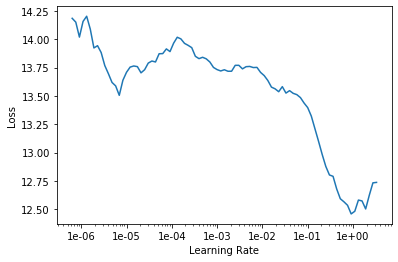

In [43]:
learn.recorder.plot()

In [44]:
learn.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,time
0,12.541354,11.698273,00:03
1,6.661193,6.550215,00:02
2,2.752909,5.650814,00:02
3,1.286201,5.565643,00:02
4,0.866370,5.555265,00:02


In [0]:
learn.save('reco')

In [0]:
learn.unfreeze()

In [47]:
learn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


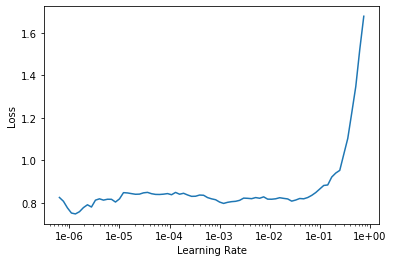

In [48]:
learn.recorder.plot()

In [49]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.800809,5.523505,00:03
1,0.658418,5.557428,00:02
2,0.419593,5.395734,00:02
3,0.177192,5.418789,00:02
4,0.082723,5.419813,00:02


In [0]:
learn.save('reco-2')

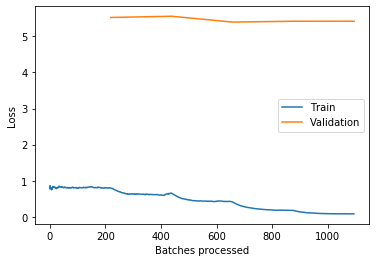

In [60]:
learn.recorder.plot_losses()

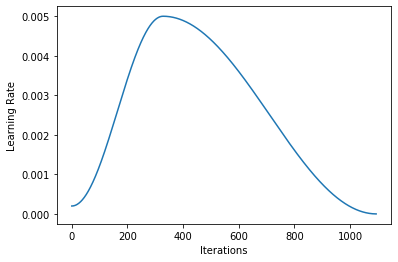

In [61]:
learn.recorder.plot_lr()

Although the train_loss is low, the valid_loss is significantly higher. I am guessing that it may be due to the small dataset size. 

## 4. Interpretation

In [51]:
learn.load('reco-2')

CollabLearner(data=TabularDataBunch;

Train: LabelList (14053 items)
x: CollabList
user_name Dounie; drama_title Dear My Friends (2016); ,user_name Pelin; drama_title Dear My Friends (2016); ,user_name silent_whispers; drama_title Dear My Friends (2016); ,user_name Dana; drama_title Dear My Friends (2016); ,user_name deliverygirl; drama_title Dear My Friends (2016); 
y: FloatList
10.0,10.0,9.0,9.0,10.0
Path: .;

Valid: LabelList (6022 items)
x: CollabList
user_name #na#; drama_title Meteor Garden (2018); ,user_name sumlee; drama_title Queen Seon Duk (2009); ,user_name #na#; drama_title The Untamed (2019); ,user_name Joanne; drama_title Rush to the Dead Summer (2017); ,user_name asiandramafan; drama_title Yah Leum Chan (2014); 
y: FloatList
8.0,10.0,10.0,5.0,7.5
Path: .;

Test: None, model=EmbeddingDotBias(
  (u_weight): Embedding(5565, 50)
  (i_weight): Embedding(2161, 50)
  (u_bias): Embedding(5565, 1)
  (i_bias): Embedding(2161, 1)
), opt_func=functools.partial(<class 'torch.optim.ad

In [62]:
g = df.groupby('drama_title')['overall_rating'].count() 
g.sort_values(ascending=False)[:10] # top 10 most highly reviewed dramas

drama_title
Healer (2014)                         231
Goblin (2016)                         204
You Who Came from the Stars (2013)    182
Kill Me, Heal Me (2015)               162
City Hunter (2011)                    151
W (2016)                              150
The Master's Sun (2013)               150
Eternal Love (2017)                   149
Descendants of the Sun (2016)         149
I Hear Your Voice (2013)              148
Name: overall_rating, dtype: int64

In [63]:
g.sort_values(ascending=False)[90:100] # top 90-100th most highly reviewed dramas

drama_title
It Started with a Kiss (2005)             24
Mother (2018)                             24
Prime Minister and I (2013)               24
The Smile Has Left Your Eyes (2018)       24
Missing 9 (2017)                          24
The Secret Life of My Secretary (2019)    24
Missing You (2012)                        24
The Gifted (2018)                         24
Pride (2004)                              24
The Rise of Phoenixes (2018)              24
Name: overall_rating, dtype: int64

To find out the dramas that are generally rated low/high regardless of what viewers are rating them, the drama bias and mean rating is found.

In [0]:
top_dramas = g.sort_values(ascending=False).index.values[:100] 
drama_bias = learn.bias(top_dramas,is_item=True)
mean_ratings = df.groupby('drama_title')['overall_rating'].mean()
drama_ratings = [(b,i,mean_ratings.loc[i],g.loc[i]) for i,b in zip(top_dramas,drama_bias)]

It seems that the dramas with highest bias are generally highly-rated. Some examples include Goblin (2016), Eternal Love (2017) and Love O2O (2016).

In [56]:
item0 = lambda o:o[0]
top_bias = sorted(drama_ratings,key=item0,reverse=True)[:10]
top_bias

[(tensor(0.8848), 'The Untamed (2019)', 9.48611111111111, 108),
 (tensor(0.8408), 'Addicted Heroin (2016)', 8.645833333333334, 72),
 (tensor(0.8181), 'Eternal Love (2017)', 9.241610738255034, 149),
 (tensor(0.8141), 'Love O2O (2016)', 8.940972222222221, 144),
 (tensor(0.7768), 'Signal (2016)', 9.712765957446809, 94),
 (tensor(0.7685), 'Goblin (2016)', 9.272058823529411, 204),
 (tensor(0.7129), 'Nirvana in Fire (2015)', 9.54, 75),
 (tensor(0.7114),
  'Weightlifting Fairy Kim Bok Joo (2016)',
  9.132575757575758,
  132),
 (tensor(0.6913), 'My Mister (2018)', 9.358024691358025, 81),
 (tensor(0.6862), 'Love by Chance (2018)', 9.237179487179487, 78)]

The opposite is true as well. Some examples include Missing 9 (2017), Missing You (2012) and Prime Minister and I (2013).

In [55]:
lowest_bias = sorted(drama_ratings,key=item0)[:10]
lowest_bias

[(tensor(0.1049), 'I  Do, I Do (2012)', 6.291666666666667, 24),
 (tensor(0.1487), 'Full House  (2004)', 7.25, 24),
 (tensor(0.1768), 'Prime Minister and I (2013)', 6.729166666666667, 24),
 (tensor(0.1774), 'Hanazakari no Kimitachi e (2007)', 8.375, 24),
 (tensor(0.2294), 'Missing 9 (2017)', 6.75, 24),
 (tensor(0.2501), 'Missing You (2012)', 7.791666666666667, 24),
 (tensor(0.2527), 'Hi! School - Love On (2014)', 6.291666666666667, 24),
 (tensor(0.2788), 'Romance is a Bonus Book (2019)', 8.583333333333334, 24),
 (tensor(0.3138), 'IRIS (2009)', 8.729166666666666, 24),
 (tensor(0.3160), 'High School King of Savvy (2014)', 7.833333333333333, 24)]

### Downsides of collaborative filtering
- We can predict with some accuracy which drama a current viewer will prefer watching. However, it is tough to do so for a new user who does not have any drama watching history.
- One way this could be overcome is by using a simple recommender system for new users first, recommending the top trending dramas. The selection of dramas and possible ratings of them could be added into the training of the collaborative filtering model.

### Conclusion
The recommender system built here was not very effective. With the validation loss much higher than the training loss, the model has overfitted. A possible way to reduce overfitting is regularization, such as reducing the dropout. A random number of activations is removed, reducing the network size, which is better to train.